# Time series analysis

Time series analysis on the rides columns (registered and casual) in the bike sharing dataset.

<a id="importing"></a>
## Importing libraries and packages

In [1]:
# Warnings
import warnings

# Mathematical operations and data manipulation
import pandas as pd

# Statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotting
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

<a id="set-paths"></a>
## Set paths

In [2]:
# Path to datasets directory
data_path = "./datasets"
# Path to assets directory (for saving results to)
assets_path = "./assets"

<a id="loading-data"></a>
## Loading dataset

In [3]:
# load hourly data
dataset = pd.read_csv(f"{data_path}/preprocessed_hour.csv")
dataset.head()

instant      dteday  season    yr  mnth  hr  holiday   weekday  workingday  \
0        1  2011-01-01  winter  2011     1   0        0  Saturday           0   
1        2  2011-01-01  winter  2011     1   1        0  Saturday           0   
2        3  2011-01-01  winter  2011     1   2        0  Saturday           0   
3        4  2011-01-01  winter  2011     1   3        0  Saturday           0   
4        5  2011-01-01  winter  2011     1   4        0  Saturday           0   

  weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0      clear  0.24  0.2879  81.0        0.0       3          13   16  
1      clear  0.22  0.2727  80.0        0.0       8          32   40  
2      clear  0.22  0.2727  80.0        0.0       5          27   32  
3      clear  0.24  0.2879  75.0        0.0       3          10   13  
4      clear  0.24  0.2879  75.0        0.0       0           1    1

In [4]:
# print some generic statistics about the data
print(f"Shape of data: {dataset.shape}")
print(f"Number of missing values in the data: {dataset.isnull().sum().sum()}")

# get statistics on the numerical columns
dataset.describe().T

Shape of data: (17379, 17)
Number of missing values in the data: 0


count         mean          std      min        25%        50%  \
instant     17379.0  8690.000000  5017.029500     1.00  4345.5000  8690.0000   
yr          17379.0  2011.502561     0.500008  2011.00  2011.0000  2012.0000   
mnth        17379.0     6.537775     3.438776     1.00     4.0000     7.0000   
hr          17379.0    11.546752     6.914405     0.00     6.0000    12.0000   
holiday     17379.0     0.028770     0.167165     0.00     0.0000     0.0000   
workingday  17379.0     0.682721     0.465431     0.00     0.0000     1.0000   
temp        17379.0     0.496987     0.192556     0.02     0.3400     0.5000   
atemp       17379.0     0.475775     0.171850     0.00     0.3333     0.4848   
hum         17379.0    62.722884    19.292983     0.00    48.0000    63.0000   
windspeed   17379.0    12.736540     8.196795     0.00     7.0015    12.9980   
casual      17379.0    35.676218    49.305030     0.00     4.0000    17.0000   
registered  17379.0   153.786869   151.357286     0.00    34.0000   115.0000   
cnt         17379.0   189.463088   181.387599     1.00    40.0000   142.0000   

                   75%         max  
instant     13034.5000  17379.0000  
yr           2012.0000   2012.0000  
mnth           10.0000     12.0000  
hr             18.0000     23.0000  
holiday         0.0000      1.0000  
workingday      1.0000      1.0000  
temp            0.6600      1.0000  
atemp           0.6212      1.0000  
hum            78.0000    100.0000  
windspeed      16.9979     56.9969  
casual         48.0000    367.0000  
registered    220.0000    886.0000  
cnt           281.0000    977.0000

<a id="plots"></a>
## Time series plots

In [5]:
# Daily rides
daily_rides = dataset[["dteday", "registered", "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()

# Convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)
daily_rides.head()

registered  casual
dteday                        
2011-01-01         654     331
2011-01-02         670     131
2011-01-03        1229     120
2011-01-04        1454     108
2011-01-05        1518      82

In [6]:
# Function for plotting rolling statistics and ADF test for time series


def test_stationarity(ts, window=10, **kwargs):
    # Dataframe for plotting
    plot_data = pd.DataFrame(ts)
    plot_data["rolling_mean"] = ts.rolling(window).mean()
    plot_data["rolling_std"] = ts.rolling(window).std()
    # Computing p-value of Dickey-Fuller test
    p_val = adfuller(ts)[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dickey-Fuller p-value: {p_val:.3f}")

<Figure size 432x288 with 0 Axes>

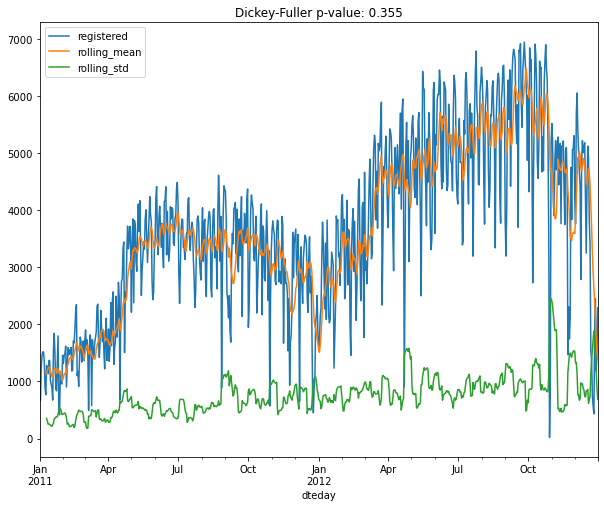

In [7]:
plt.figure()
test_stationarity(daily_rides["registered"], figsize=(10, 8))
plt.savefig(f"{assets_path}/daily_registered_original.png", format="png")

<Figure size 432x288 with 0 Axes>

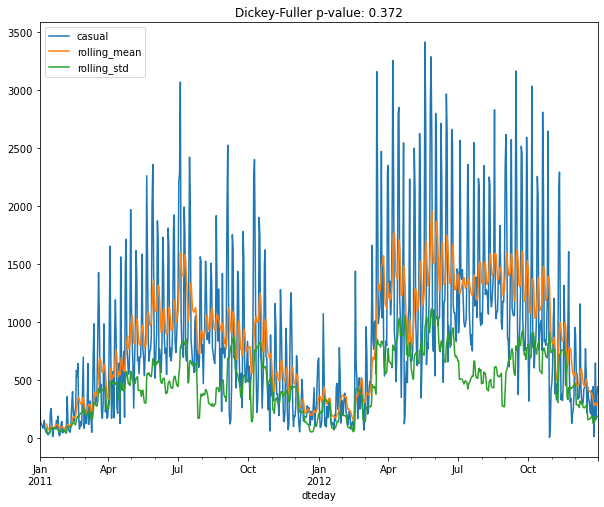

In [8]:
plt.figure()
test_stationarity(daily_rides["casual"], figsize=(10, 8))
plt.savefig(f"{assets_path}/daily_casual_original.png", format="png")

In [9]:
# Making time series stationary
registered = daily_rides["registered"]
registered_ma = registered.rolling(10).mean()
registered_ma_diff = registered - registered_ma
registered_ma_diff.dropna(inplace=True)

casual = daily_rides["casual"]
casual_ma = casual.rolling(10).mean()
casual_ma_diff = casual - casual_ma
casual_ma_diff.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

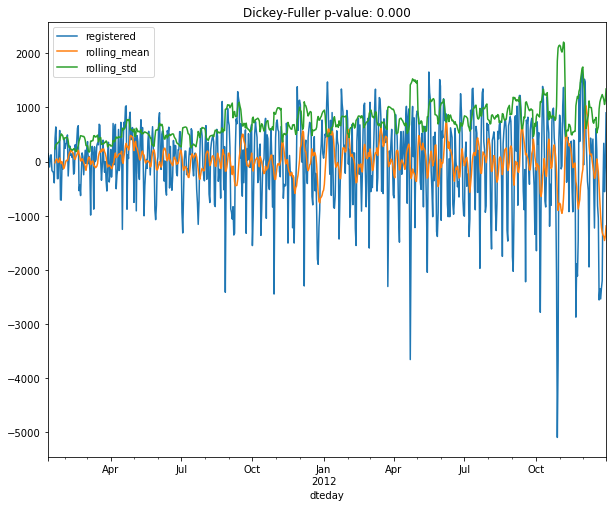

In [10]:
plt.figure()
test_stationarity(registered_ma_diff, figsize=(10, 8))
plt.savefig(f"{assets_path}/daily_registered_ma_diff.png", format="png")

<Figure size 432x288 with 0 Axes>

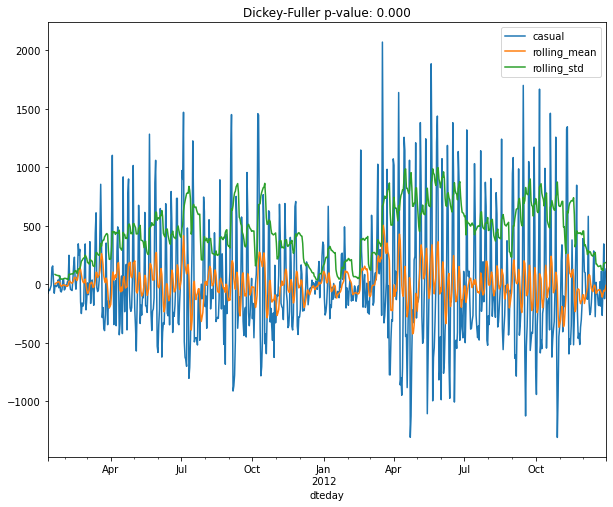

In [11]:
plt.figure()
test_stationarity(casual_ma_diff, figsize=(10, 8))
plt.savefig(f"{assets_path}/daily_casual_ma_diff.png", format="png")

In [12]:
# Subtracting last value
registered = daily_rides["registered"]
registered_diff = registered - registered.shift()
registered_diff.dropna(inplace=True)

casual = daily_rides["casual"]
casual_diff = casual - casual.shift()
casual_diff.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

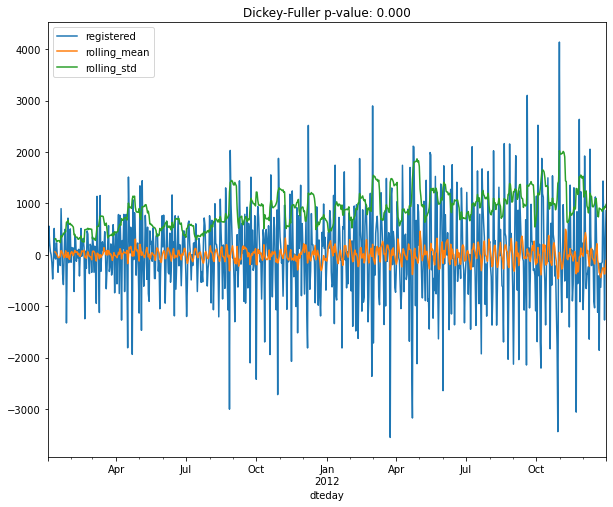

In [13]:
plt.figure()
test_stationarity(registered_diff, figsize=(10, 8))
plt.savefig(f"{assets_path}/daily_registered_diff.png", format="png")

<Figure size 432x288 with 0 Axes>

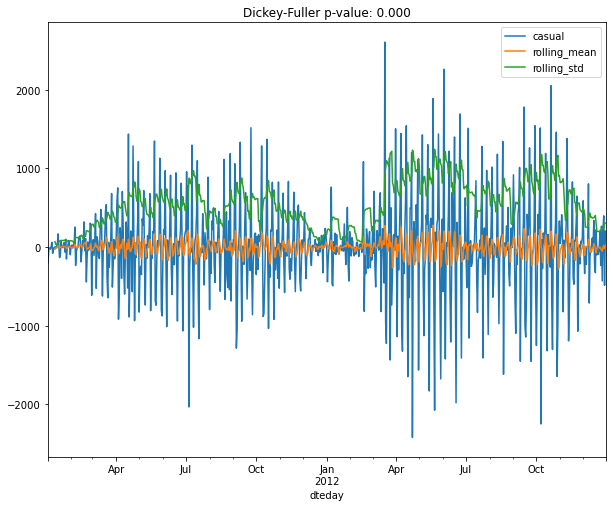

In [14]:
plt.figure()
test_stationarity(casual_diff, figsize=(10, 8))
plt.savefig(f"{assets_path}/daily_casual_diff.png", format="png")

<a id="decomposition"></a>
## Time series decomposition in trend, seasonality, and residual components

In [15]:
registered_decomposition = seasonal_decompose(daily_rides["registered"])
casual_decomposition = seasonal_decompose(daily_rides["casual"])

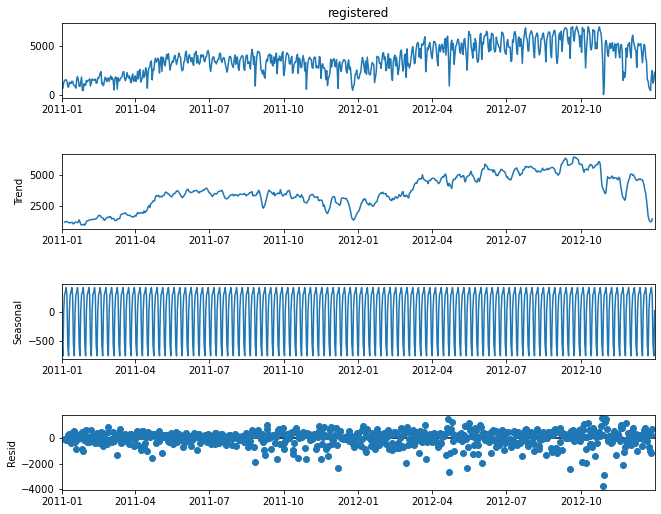

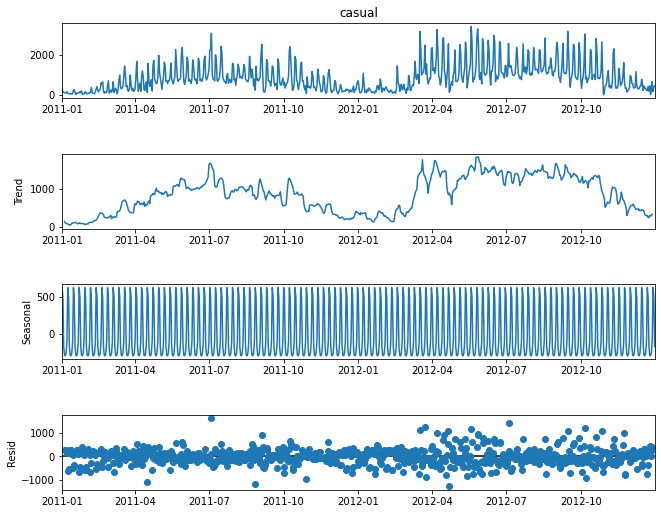

In [16]:
# Plotting decompositions
registered_plot = registered_decomposition.plot()
registered_plot.set_size_inches(10, 8)

casual_plot = casual_decomposition.plot()
casual_plot.set_size_inches(10, 8)

registered_plot.savefig(
    f"{assets_path}/registered_decomposition.png", format="png"
)
casual_plot.savefig(f"{assets_path}/casual_decomposition.png", format="png")

<Figure size 432x288 with 0 Axes>

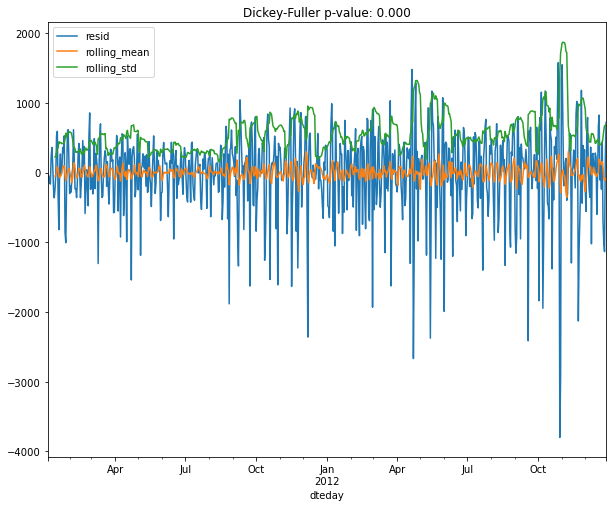

In [17]:
# Testing residuals for stationarity
plt.figure()
test_stationarity(registered_decomposition.resid.dropna(), figsize=(10, 8))
plt.savefig(f"{assets_path}/registered_resid.png", format="png")